In [2]:
from datetime import datetime
import json
import openturns as ot
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd 
import seaborn as sns
from plot import plot_tpd

from data_preparation import prepro_data_pce, preprocess_field_data, prepro_data_gp

from sklearn.model_selection import train_test_split



BASE_DIRECTORY = '/Users/edgarjaber/Desktop/Articles/codes folder/Bayes-calibration-for-clogging-prognostics/DATA/'
SIMULATION_TIME = np.load(BASE_DIRECTORY + 'simulation_data/LHS/t_gv.npy', allow_pickle=True)

csv_file = BASE_DIRECTORY + 'field_data/field_data.csv'
input_dic = json.load(open(BASE_DIRECTORY + 'meta_data/SG_cleaning_conditioning.json'))
cleaning_dates = [input_dic['chemistry']['cleaning'][i]['time']/24 for i in range(len(input_dic['chemistry']['cleaning']))]

HOURLY_GRID = np.linspace(0, 420481, 420481).astype(int)

T0 = 563846400

plt.rcParams['figure.dpi']= 200
plt.rcParams['text.usetex'] = True

In [3]:
data, time_indices = preprocess_field_data(csv_file=csv_file, 
                                           operation_time=SIMULATION_TIME, 
                                           cleaning_dates=cleaning_dates, 
                                           with_time_division=True)

In [3]:
with open(BASE_DIRECTORY +  '/metamodels/PCE/PCE_full_5_07_mc.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    VPCE = unpickler.load()

Running Polynomial Chaos Expansion with regression method for degree 5, q-norm 0.7


WRN - set the component 25 of contributor 3=0 to zero as it is too small
WRN - set the component 28 of contributor 4=0 to zero as it is too small
WRN - set the component 72 of contributor 4=0 to zero as it is too small
WRN - set the component 73 of contributor 4=0 to zero as it is too small
WRN - set the component 74 of contributor 4=0 to zero as it is too small
WRN - set the component 21 of contributor 5=0 to zero as it is too small
WRN - set the component 42 of contributor 5=0 to zero as it is too small


In [4]:
### DATA ###
lhs_hl = np.load(BASE_DIRECTORY + 'simulation_data/LHS/doe_hl.npy', allow_pickle=True)
lhs_cl = np.load(BASE_DIRECTORY + 'simulation_data/LHS/doe_cl.npy', allow_pickle=True)

mc_hl = np.load(BASE_DIRECTORY + 'simulation_data/MC/doe_hl.npy', allow_pickle=True)
mc_cl = np.load(BASE_DIRECTORY + 'simulation_data/MC/doe_cl.npy', allow_pickle=True)


In [5]:
prior_distribution = ot.Uniform(0, 15e-4)

n_max = lhs_hl.shape[0]
n_samp = 1000

X, y = prepro_data_pce(mc_hl, mc_cl, n_max, n_samp, 2)
X_gp, y_gp = prepro_data_gp(mc_hl, mc_cl, SIMULATION_TIME, n_max, n_samp, 2, scale=False)
#y_interpolated = np.asarray([np.interp(HOURLY_GRID, SIMULATION_TIME*24, y[i,:]) for i in range(len(y))])

0 nan trajectories in output sample


Text(0.5, 0.98, 'Different DoE of THYC-Puffer-DEPO simulation model')

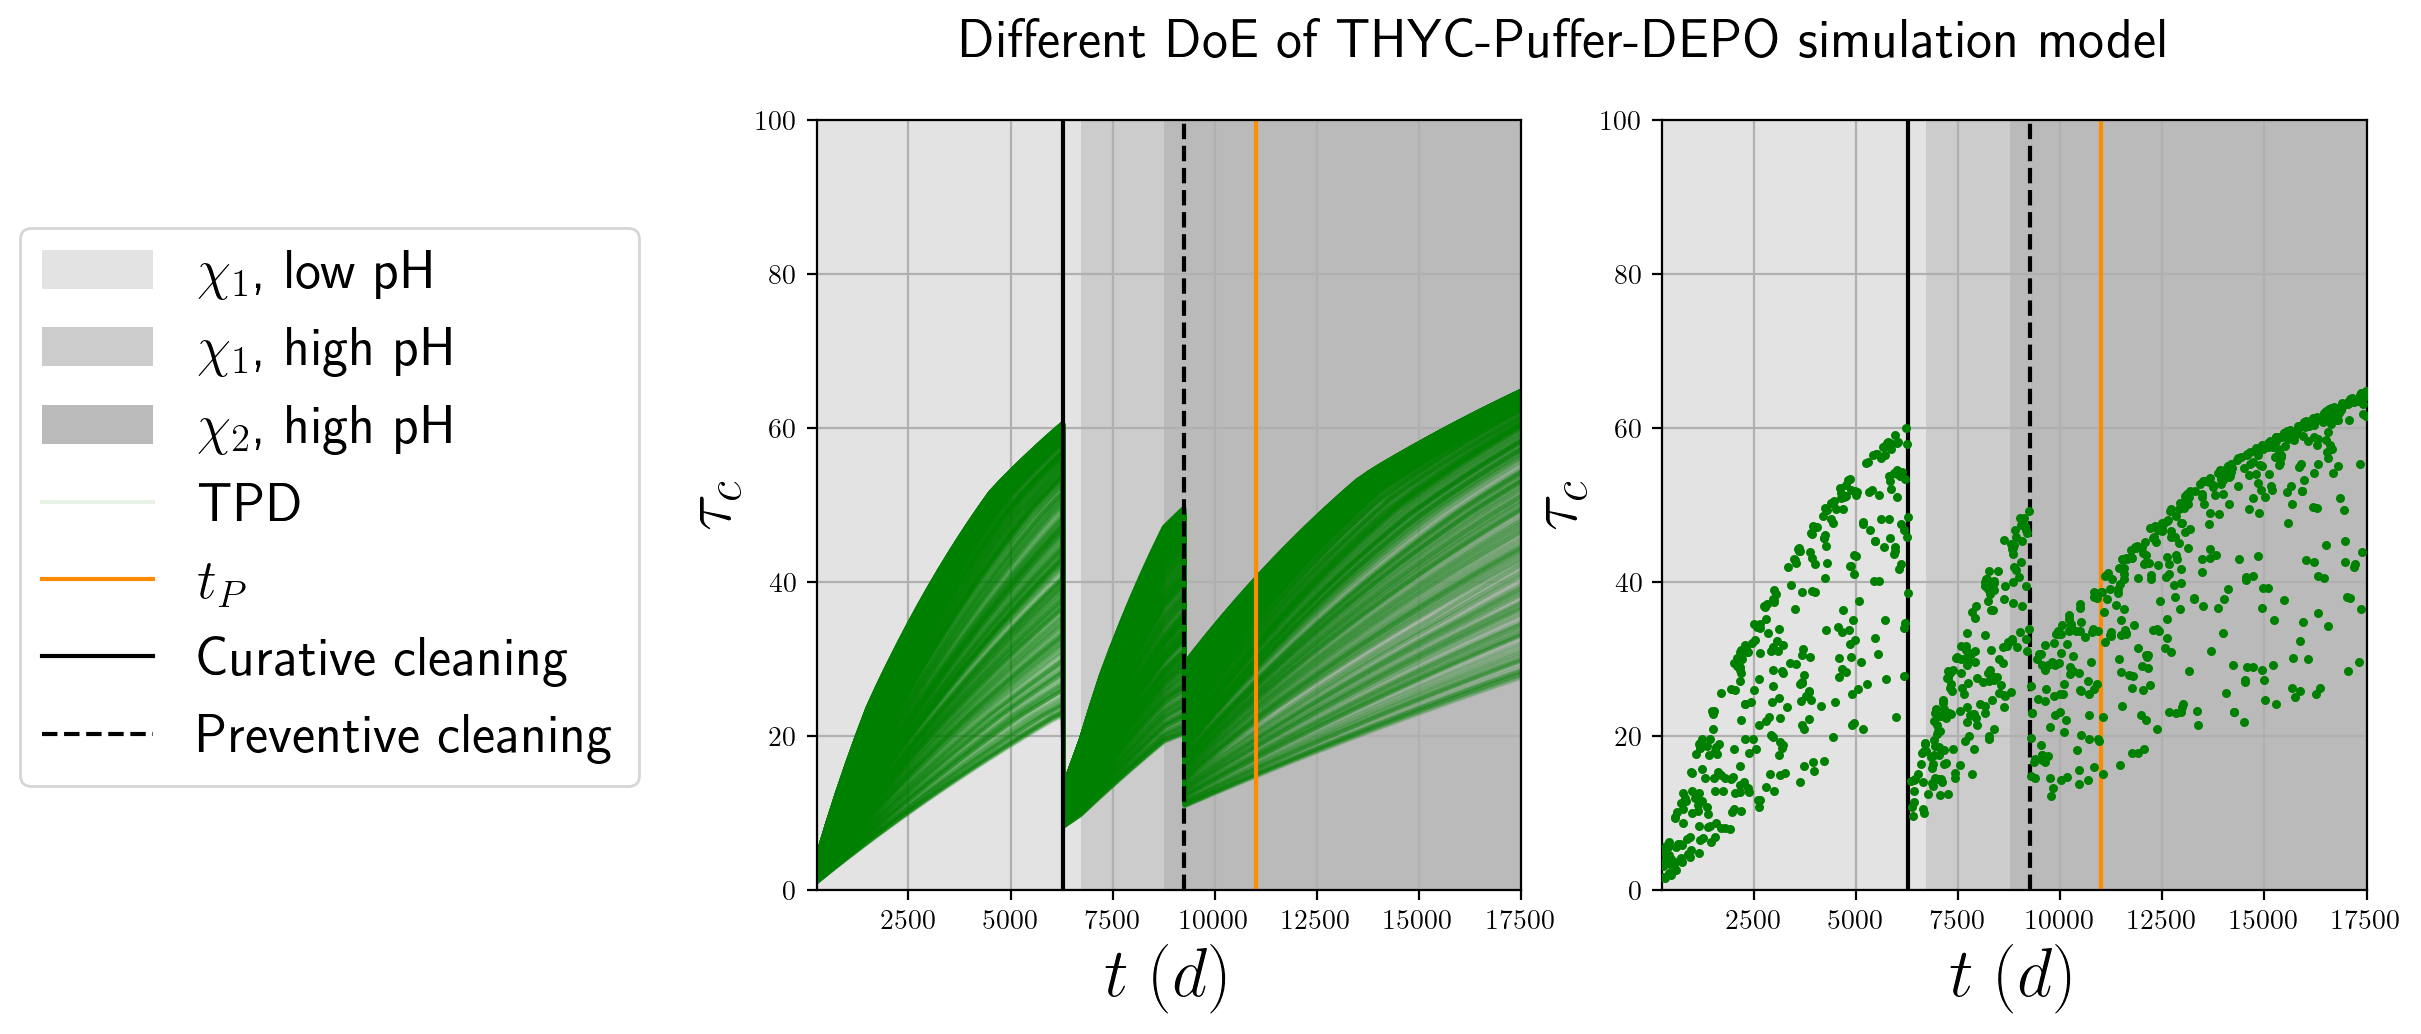

In [10]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0] = plot_tpd(axs[0], input_dic, y, SIMULATION_TIME, 'TPD')
axs[1] = plot_tpd(axs[1], input_dic, y_gp, X_gp[:,1]/24, 'TPD')

lines_labels = [axs[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.05,0.8), fontsize=20)

fig.suptitle('Different DoE of THYC-Puffer-DEPO simulation model', fontsize=20)

/Users/edgarjaber/miniconda3/envs/bayes_calib/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/edgarjaber/miniconda3/envs/bayes_calib/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


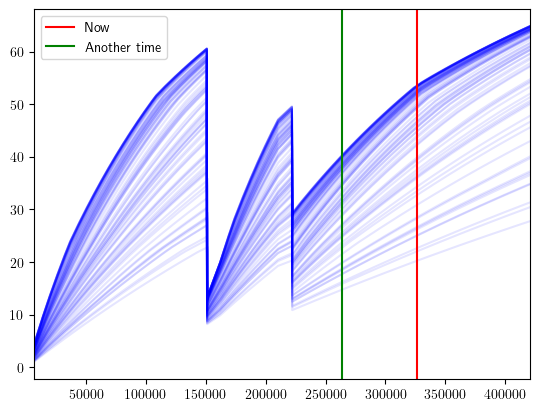

In [74]:
for i in range(100):
    plt.plot(HOURLY_GRID, y_interpolated[i,:], color='blue', alpha=0.1)
plt.xlim(250*24, max(HOURLY_GRID))
plt.axvline(x=(datetime.now().timestamp()-T0)/3600, color='red', label='Now')
plt.axvline(x=(10996.875)*24, color='green', label='Another time')
plt.legend()


In [75]:
now = ((datetime.now().timestamp() - T0)/3600)
another_now = cleaning_dates[1]

In [76]:
((now - another_now)/24)/365 # years

36.16484506823884

# Prior RUL

In [77]:
start_clean = np.where(SIMULATION_TIME > int(another_now))

In [78]:
traj = y[:,start_clean[0][0]:]

In [79]:
prognostics_time = SIMULATION_TIME[start_clean[0][0]:]    

In [80]:
thresholds = [30, 40, 50]
ruls = []
for threshold in thresholds:
    rul = []
    for i in range(n_samp):
        for j in range(start_clean[0].shape[0]):
            if traj[i, j] > threshold:
                rul.append(prognostics_time[j]-SIMULATION_TIME[start_clean[0][0]])
                break
    ruls.append(rul)
ruls = pd.DataFrame(ruls).T

Text(0.5, 1.0, 'RUL distribution for different thresholds before calibration')

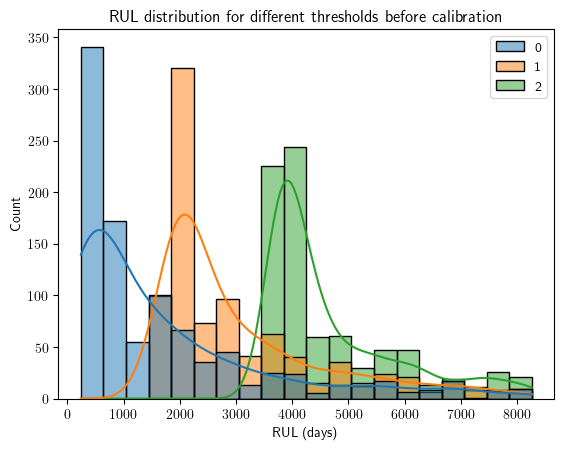

In [82]:
sns.histplot(ruls, kde=True, bins=20, color='blue')   
plt.xlabel('RUL (days)')
plt.title('RUL distribution for different thresholds before calibration')

# Updated RUL

In [103]:
sample_gp = np.load(BASE_DIRECTORY + '/posterior_samples/sample_gp.npy')
sample_pce = np.load(BASE_DIRECTORY + '/posterior_samples/sample_pce.npy')
sample_kl = np.load(BASE_DIRECTORY + '/posterior_samples/sample_kl.npy')

In [104]:
y_1 = np.asarray(VPCE.predict(sample_pce[:, 0].reshape(-1,1)))
y_2 = np.asarray(VPCE.predict(sample_pce[:, 1].reshape(-1,1)))
y_3 = np.asarray(VPCE.predict(sample_pce[:, 2].reshape(-1,1)))

In [105]:
nc1 = np.where((SIMULATION_TIME*24).astype(int) == 150792)[0][0]
nc2 = np.where((SIMULATION_TIME*24).astype(int) == 221928)[0][0]

In [106]:
y_new = np.concatenate((y_1[:,:nc1+1], np.concatenate((y_2[:,nc1+1:nc2+1], y_3[:,nc2+1:]), axis=1)), axis=1)

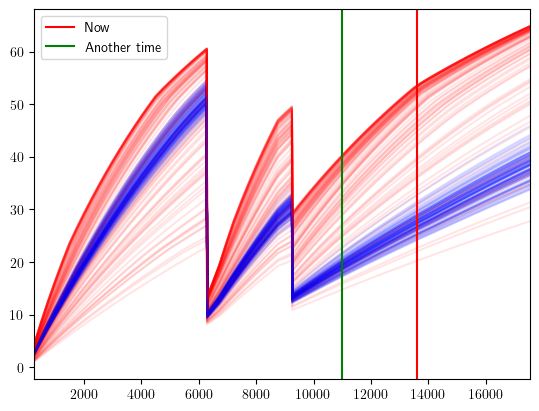

In [107]:
for i in range(100):
    plt.plot(SIMULATION_TIME, y_new[i,:], color='blue', alpha=0.1)
    plt.plot(SIMULATION_TIME, y[i,:], color='red', alpha=0.1)

plt.xlim(250, max(SIMULATION_TIME))
plt.axvline(x=((datetime.now().timestamp()-T0)/3600)/24, color='red', label='Now')
plt.axvline(x=(10996.875), color='green', label='Another time')
plt.legend()


In [88]:
start_clean = np.where(SIMULATION_TIME > int(another_now))

In [89]:
traj = y[:,start_clean[0][0]:]

In [90]:
prognostics_time = SIMULATION_TIME[start_clean[0][0]:]    

In [91]:
#thresholds = [40, 50, 60]
ruls = []
for threshold in thresholds:
    rul = []
    for i in range(n_samp):
        for j in range(start_clean[0].shape[0]):
            if traj[i, j] > threshold:
                rul.append(prognostics_time[j]-SIMULATION_TIME[start_clean[0][0]])
                break
    ruls.append(rul)
ruls = pd.DataFrame(ruls).T

Text(0.5, 1.0, 'RUL distribution for different thresholds before calibration')

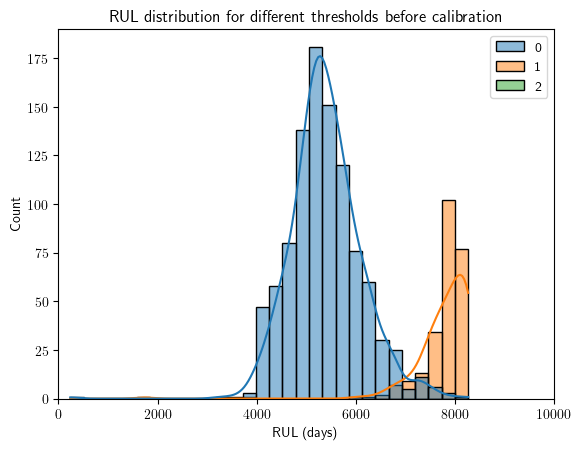

In [96]:
sns.histplot(ruls, kde=True, bins=30, color='blue')   
plt.xlim(0, 10000)
plt.xlabel('RUL (days)')
plt.title('RUL distribution for different thresholds before calibration')

# Ignore

In [4]:
from metamodels import VPCEMetamodel

### DATA ###
lhs_hl = np.load('/Users/edgarjaber/Desktop/codes.nosync/calibration_full/DATA/gv_900/code_data/x_theta_t/LHS/doe_hl.npy', allow_pickle=True)
lhs_cl = np.load('/Users/edgarjaber/Desktop/codes.nosync/calibration_full/DATA/gv_900/code_data/x_theta_t/LHS/doe_cl.npy', allow_pickle=True)

n_max = lhs_hl.shape[0]
n_samp = 1000

X, y = prepro_data_pce(lhs_hl, lhs_cl, n_max, n_samp, 8)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

DEGREE, QNORM = 3, 0.8

14 nan trajectories in output sample


In [5]:
alpha = ot.Uniform(100.0, 103.0)
beta = ot.Uniform(0.02, 0.025)
eps_e = ot.Uniform(0.2, 0.5)
eps_c = ot.Uniform(0.01, 0.3)
d_p = ot.Uniform(0.5e-6, 10.0e-6)
g_p0 = ot.Uniform(1.0e-9, 8.0e-9)
a_v = ot.Uniform(0.0, 15e-4)

prior_list = [alpha, beta, eps_e, eps_c, d_p, g_p0, a_v]

In [6]:
VPCE = VPCEMetamodel(degree=DEGREE, q_norm=QNORM, input_dimension=7, prior_list=prior_list)

In [15]:
VPCE.fit(X_train, y_train)

Running Polynomial Chaos Expansion with regression method for degree 3, q-norm 0.5


WRN - set the component 3 of contributor 6=0 to zero as it is too small
WRN - set the component 4 of contributor 6=0 to zero as it is too small
WRN - set the component 5 of contributor 6=0 to zero as it is too small
WRN - set the component 6 of contributor 6=0 to zero as it is too small
WRN - set the component 7 of contributor 6=0 to zero as it is too small
WRN - set the component 8 of contributor 6=0 to zero as it is too small
WRN - set the component 9 of contributor 6=0 to zero as it is too small
WRN - set the component 10 of contributor 6=0 to zero as it is too small
WRN - set the component 11 of contributor 6=0 to zero as it is too small
WRN - set the component 12 of contributor 6=0 to zero as it is too small
WRN - set the component 13 of contributor 6=0 to zero as it is too small
WRN - set the component 14 of contributor 6=0 to zero as it is too small
WRN - set the component 15 of contributor 6=0 to zero as it is too small
WRN - set the component 16 of contributor 6=0 to zero as i

Running Polynomial Chaos Expansion with regression method for degree 3, q-norm 1.0


WRN - set the component 26 of contributor 1=0 to zero as it is too small
WRN - set the component 0 of contributor 7=0 to zero as it is too small
WRN - set the component 1 of contributor 7=0 to zero as it is too small
WRN - set the component 2 of contributor 7=0 to zero as it is too small
WRN - set the component 3 of contributor 7=0 to zero as it is too small
WRN - set the component 4 of contributor 7=0 to zero as it is too small
WRN - set the component 5 of contributor 7=0 to zero as it is too small
WRN - set the component 6 of contributor 7=0 to zero as it is too small
WRN - set the component 7 of contributor 7=0 to zero as it is too small
WRN - set the component 8 of contributor 7=0 to zero as it is too small
WRN - set the component 9 of contributor 7=0 to zero as it is too small
WRN - set the component 10 of contributor 7=0 to zero as it is too small
WRN - set the component 11 of contributor 7=0 to zero as it is too small
WRN - set the component 12 of contributor 7=0 to zero as it i

Running Polynomial Chaos Expansion with regression method for degree 3, q-norm 0.8


WRN - set the component 26 of contributor 1=0 to zero as it is too small
WRN - set the component 0 of contributor 7=0 to zero as it is too small
WRN - set the component 1 of contributor 7=0 to zero as it is too small
WRN - set the component 2 of contributor 7=0 to zero as it is too small
WRN - set the component 3 of contributor 7=0 to zero as it is too small
WRN - set the component 4 of contributor 7=0 to zero as it is too small
WRN - set the component 5 of contributor 7=0 to zero as it is too small
WRN - set the component 6 of contributor 7=0 to zero as it is too small
WRN - set the component 7 of contributor 7=0 to zero as it is too small
WRN - set the component 8 of contributor 7=0 to zero as it is too small
WRN - set the component 9 of contributor 7=0 to zero as it is too small
WRN - set the component 10 of contributor 7=0 to zero as it is too small
WRN - set the component 11 of contributor 7=0 to zero as it is too small
WRN - set the component 12 of contributor 7=0 to zero as it i

Running Polynomial Chaos Expansion with regression method for degree 3, q-norm 0.8


WRN - set the component 26 of contributor 1=0 to zero as it is too small
WRN - set the component 0 of contributor 7=0 to zero as it is too small
WRN - set the component 1 of contributor 7=0 to zero as it is too small
WRN - set the component 2 of contributor 7=0 to zero as it is too small
WRN - set the component 3 of contributor 7=0 to zero as it is too small
WRN - set the component 4 of contributor 7=0 to zero as it is too small
WRN - set the component 5 of contributor 7=0 to zero as it is too small
WRN - set the component 6 of contributor 7=0 to zero as it is too small
WRN - set the component 7 of contributor 7=0 to zero as it is too small
WRN - set the component 8 of contributor 7=0 to zero as it is too small
WRN - set the component 9 of contributor 7=0 to zero as it is too small
WRN - set the component 10 of contributor 7=0 to zero as it is too small
WRN - set the component 11 of contributor 7=0 to zero as it is too small
WRN - set the component 12 of contributor 7=0 to zero as it i

In [8]:
test = np.asarray(VPCE.predict(ot.ComposedDistribution(prior_list).getSample(1000)))

In [9]:
sample = np.asarray(ot.ComposedDistribution(prior_list).getSample(1000))
sample_gp = np.load(BASE_DIRECTORY + '/posterior_samples/sample_gp.npy')

y = np.asarray(VPCE.predict(sample))

In [10]:
sample_1, sample_2, sample_3 = sample.copy(), sample.copy(), sample.copy()
sample_1[:, 6] = sample_gp[:, 0]
sample_2[:, 6] = sample_gp[:, 1]
sample_3[:, 6] = sample_gp[:, 2]

In [11]:
y_1 = np.asarray(VPCE.predict(sample_1))
y_2 = np.asarray(VPCE.predict(sample_2))
y_3 = np.asarray(VPCE.predict(sample_3))

In [12]:
nc1 = np.where((SIMULATION_TIME*24).astype(int) == 150792)[0][0]
nc2 = np.where((SIMULATION_TIME*24).astype(int) == 221928)[0][0]

In [13]:
y_new = np.concatenate((y_1[:,:nc1+1], np.concatenate((y_2[:,nc1+1:nc2+1], y_3[:,nc2+1:]), axis=1)), axis=1)

Text(0.5, 0.98, 'TPD simulations with prior distributions and after $\\theta$ calibration')

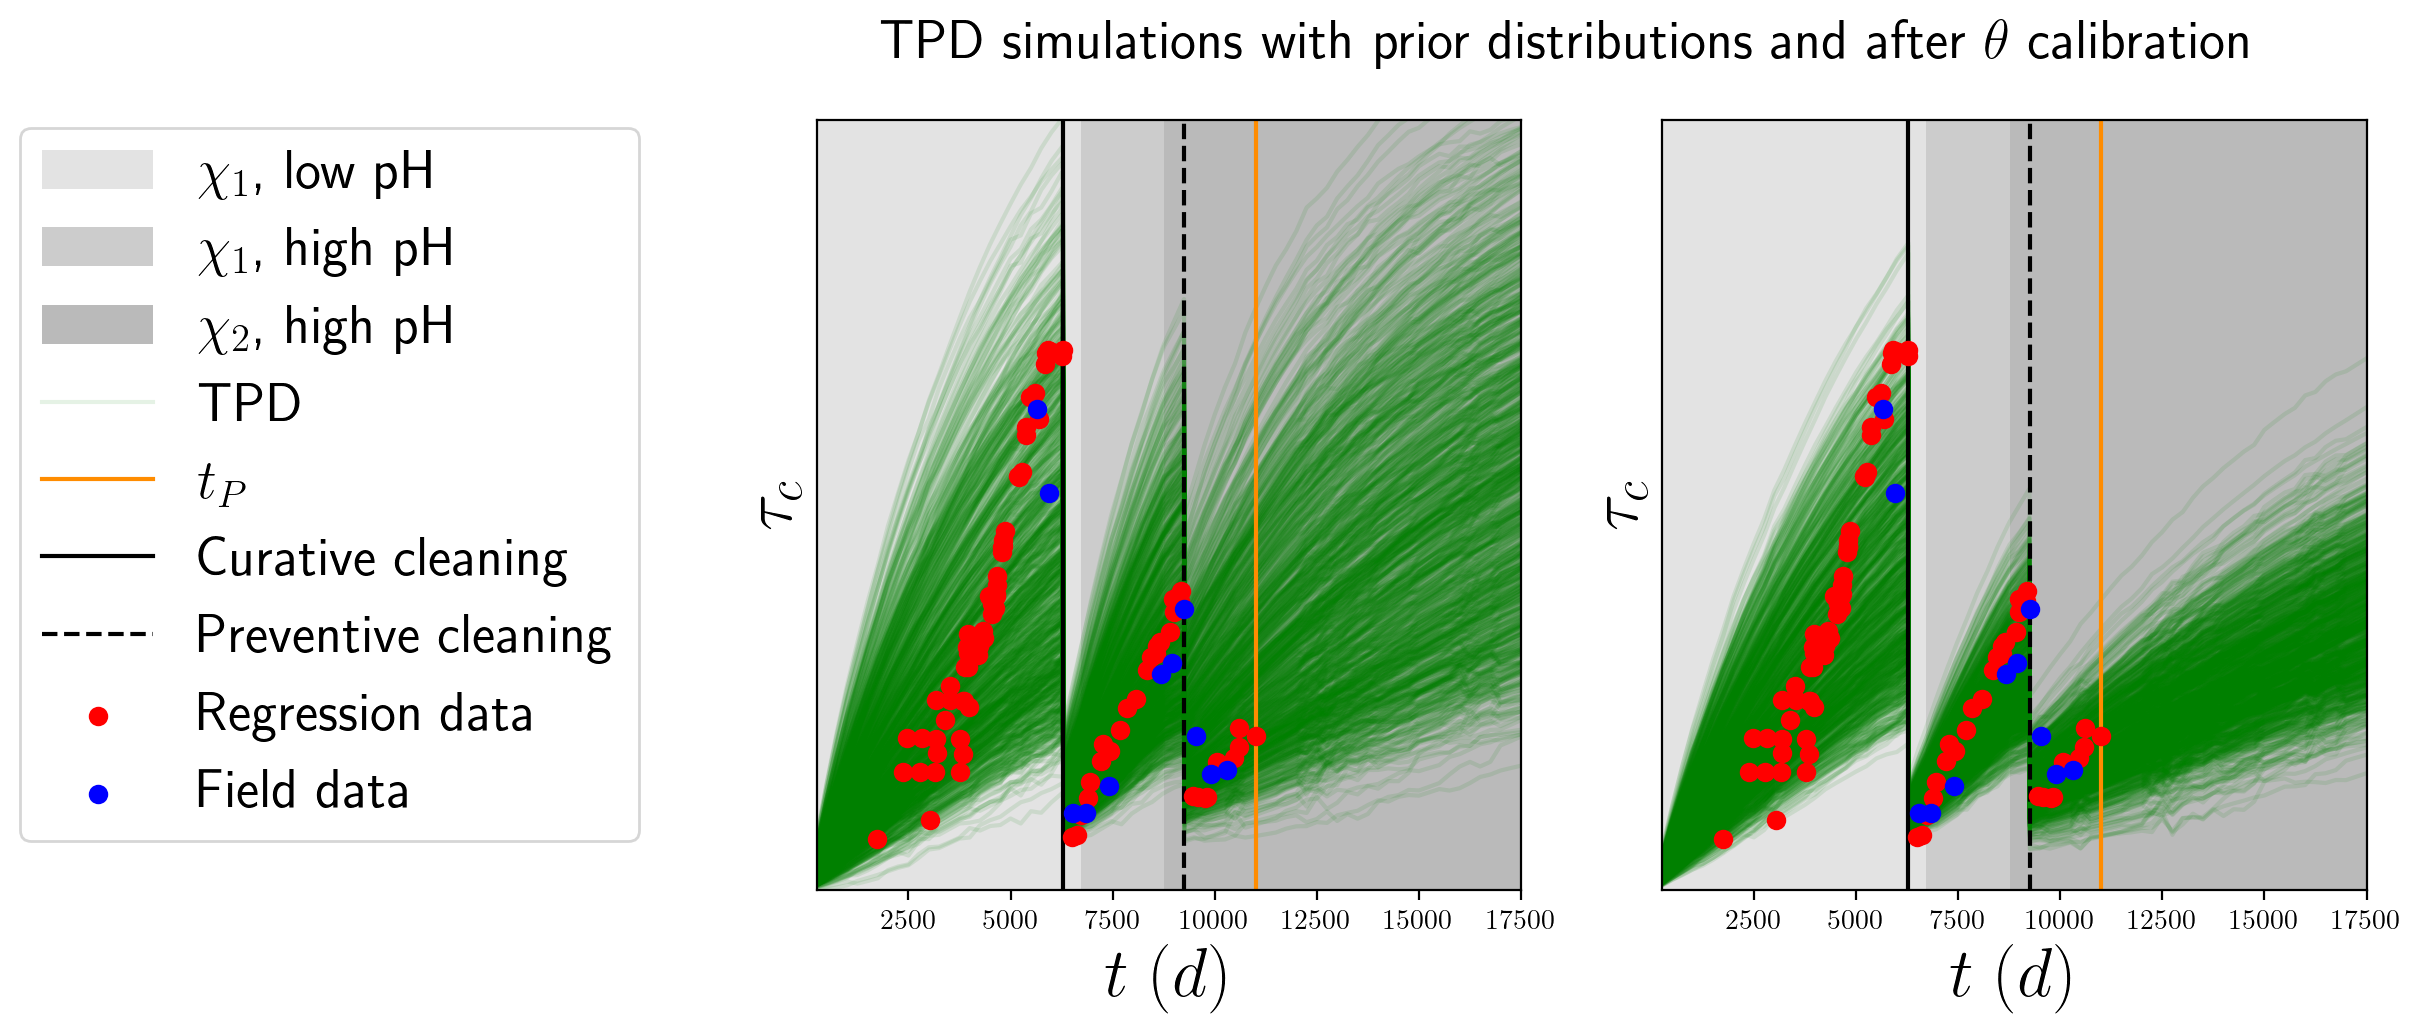

In [14]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0] = plot_tpd(axs[0], input_dic, y, SIMULATION_TIME, 'TPD')
axs[1] = plot_tpd(axs[1], input_dic, y_new, SIMULATION_TIME, 'TPD')

for i in range(3):
    if i == 0:
        axs[0].scatter(data[i][0][:, 0], data[i][0][:, 1], color='red', label='Regression data', zorder=10)
        axs[0].scatter(data[i][1][:, 0], data[i][1][:, 1], color='blue', label='Field data', zorder=10)
        axs[1].scatter(data[i][0][:, 0], data[i][0][:, 1], color='red', zorder=10)
        axs[1].scatter(data[i][1][:, 0], data[i][1][:, 1], color='blue', zorder=10)
    else:
        axs[0].scatter(data[i][0][:, 0], data[i][0][:, 1], color='red',  zorder=10)
        axs[0].scatter(data[i][1][:, 0], data[i][1][:, 1], color='blue', zorder=10)
        axs[1].scatter(data[i][0][:, 0], data[i][0][:, 1], color='red', zorder=10)
        axs[1].scatter(data[i][1][:, 0], data[i][1][:, 1], color='blue', zorder=10)

axs[0].grid(False)
axs[1].grid(False)

axs[0].set_yticks([])
axs[1].set_yticks([])

lines_labels = [axs[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.05,0.9), fontsize=20)

fig.suptitle(r'TPD simulations with prior distributions and after $\theta$ calibration', fontsize=20)

In [17]:
np.save(BASE_DIRECTORY + 'y.npy', y)
np.save(BASE_DIRECTORY + 'sample.npy', sample)
np.save(BASE_DIRECTORY + 'sample_1.npy', sample_1)
np.save(BASE_DIRECTORY + 'sample_2.npy', sample_2)
np.save(BASE_DIRECTORY + 'sample_3.npy', sample_3)
np.save(BASE_DIRECTORY + 'y_new.npy', y_new)